# Real Time Gait Asymmetry Detection  

In this notebook we are going to achieve the following:

1. **Create the Training Dataset**: We will preprocess and combine data from different sources to create a comprehensive training dataset for real time gait asymmetry detection.
2. **Feature Selection and Dimensionality Reduction**: We will identify the most relevant features for real time gait asymmetry detection using dimensionality reduction techniques.
3. **Model Evaluation**: We will test and compare the performance of multiple machine learning and deep learning algorithms for real time gait asymmetry detection.

In [ ]:
# Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras import Input
from feature_extraction import generate_rolling_windows
from data_preprocessing import clean_extra_files, detection_merge_subject_features, detection_merge_raw_npz_files, detection_merge_csv_datasets, detection_merge_npz_datasets


# Constants
base_dir    = 'Data'
healthy_dir = 'Data/Healthy'
stroke_dir  = 'Data/Stroke'

detection_time_domain_name = 'detection_time_domain.csv'
detection_asymmetry_name   = 'detection_asymmetry.csv'

## Data Preprocessing, Feature Selection and Dimensionality Reduction

The first step is to create the dataset for the gait asymmetry and extract meaningful features from raw data. The goal is to create a set of different datasets that will provide a holistic view and different insights that we can use with the aim of creating a model that will provide a real time gait asymmetry detection. The process here includes the following steps:
1. Create a new base dataset that includes data in 2 second windows and a 1 second stride.
2. Extract simple statistic features from the 2 second signal like max, min and std. The simple statistics proved to be meaningful information for the classification task.
3. Extract a set of simple symmetry and asymmetry features from swing and stride times.

The data provided were designed for classification, since we have only a label for the whole signal as either 'Stroke Patient' or 'Healthy Subject'. In order to create the new real time asymmetry detection model we need to ensure that we have the correct labels. According to [Physio-pedia](https://www.physio-pedia.com/The_Gait_Cycle) the average gait cycle of a healthy adult is [1.2, 1.8] seconds. Taking into consideration the fact that impaired patients tend to have a longer stride we choose to use a 2 second window with a 1 second stride.

In [ ]:
# # Create the new datasets for the healthy subjects

# # 1. Create all the feature files for the statistical, asymmetry and raw data 
# for patient_id in os.listdir(healthy_dir):
#     patient_path = os.path.join(healthy_dir, patient_id)
    
#     if not os.path.isdir(patient_path) or patient_path.__contains__('.DS_Store'):
#         continue
#     #
#     try:
#         generate_rolling_windows(patient_path)
#     except Exception as e:
#         print(f'Error processing {patient_id}: {e}')
        
# # 2. Merge all type of datasets into a single file for better training
# detection_merge_subject_features(healthy_dir, detection_time_domain_name, detection_time_domain_name)
# detection_merge_subject_features(healthy_dir, detection_asymmetry_name, detection_asymmetry_name)
# detection_merge_raw_npz_files(healthy_dir)

In [ ]:
# # Create the new datasets for the stroke patients

# # 1. Create all the feature files for the statistical, asymmetry and raw data 
# for patient_id in os.listdir(stroke_dir):
#     patient_path = os.path.join(stroke_dir, patient_id)
    
#     if not os.path.isdir(patient_path) or patient_path.__contains__('.DS_Store'):
#         continue
    
#     try:
#         generate_rolling_windows(patient_path)
#     except Exception as e:
#         print(f'Error processing {patient_id}: {e}')
        
# # 2. Merge all type of datasets into a single file for better training
# detection_merge_subject_features(stroke_dir, detection_time_domain_name, detection_time_domain_name)
# detection_merge_subject_features(stroke_dir, detection_asymmetry_name, detection_asymmetry_name)
# detection_merge_raw_npz_files(stroke_dir)

In [ ]:
# # Merge the healthy subjects and stroke patients to a single file
# detection_merge_csv_datasets(healthy_dir, stroke_dir, detection_time_domain_name)
# detection_merge_csv_datasets(healthy_dir, stroke_dir, detection_asymmetry_name)
# detection_merge_npz_datasets(base_dir)

## Gait Asymmetry Detection — Time-Domain Feature Model

This part of the notebook trains a binary classifier to detect gait asymmetry using time-domain features extracted from rolling IMU windows.

In [ ]:
# Load Dataset
time_domain_data = pd.read_csv('detection_time_domain.csv')

# Filter for Gait Windows Only (label 0 or 1)
data_time_domain_gait = time_domain_data[time_domain_data['label_moderate'].isin([0, 1])].copy()
target_variable = 'label_moderate'

# Calculate class frequencies
class_counts = data_time_domain_gait[target_variable].value_counts()
bars = ['Asymmetric Gait', 'Symmetric Gait']
labels_position = np.arange(len(bars))


# Visualize class distribution
class_counts.plot(kind='bar')
plt.title('Class Balance')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(labels_position, bars, rotation=360, fontsize='13')
plt.show()

In [ ]:
# Define Features and Labels
feature_cols = [
    'gyro-right-z-axis-max', 'gyro-left-z-axis-max',
    'gyro-right-z-axis-min', 'gyro-left-z-axis-min',
    'accel-right-z-axis-max', 'accel-left-z-axis-max',
    'accel-right-z-axis-min', 'accel-left-z-axis-min'
]

labels = ['label_strict', 'label_moderate', 'label_lenient']


for label in labels:
    label_type = label.split('_')[1]
    X = data_time_domain_gait[feature_cols].values
    y = data_time_domain_gait[label].values
    groups = data_time_domain_gait['patient_id'].values

    # Normalize Features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Cross-Validation Setup
    gkf = GroupKFold(n_splits=5)

    # Define All Models to Compare
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Gradient Boosting': GradientBoostingClassifier(),
        'MLP': MLPClassifier(hidden_layer_sizes=(50,), max_iter=3000, alpha=1e-4),
        'SVM (linear)': SVC(kernel='linear', probability=True),
        'XGBoost': xgb.XGBClassifier(eval_metric='logloss')
    }


    # Train and Evaluate All Models
    results = {}

    for name, model in models.items():
        print(f'\nTraining model: {name}')
        y_true_all, y_pred_all = [], []

        # Training and Evaluation
        for fold, (train_idx, test_idx) in enumerate(gkf.split(X_scaled, y, groups)):
                model.fit(X_scaled[train_idx], y[train_idx])
                y_pred = model.predict(X_scaled[test_idx])
                y_true_all.extend(y[test_idx])
                y_pred_all.extend(y_pred)
                
        report = classification_report(y_true_all, y_pred_all, output_dict=True)
        results[name] = report
        print(classification_report(y_true_all, y_pred_all, digits=3))



    # Compare Models (Accuracy and F1)
    summary = pd.DataFrame({
        model: {
            'accuracy': results[model]['accuracy'],
            'f1_score_asymmetry': results[model]['1']['f1-score'],
            'precision_asymmetry': results[model]['1']['precision'],
            'recall_asymmetry': results[model]['1']['recall']
        }
        for model in results
    }).T


    summary = summary.sort_values(by='f1_score_asymmetry', ascending=False)
    print('\n Model Comparison Summary:')
    display(summary)

    # ## Plot Summary
    summary.plot(kind='bar', figsize=(12,6))
    plt.title(f'Model Comparison on Asymmetry Detection ({label_type} label)')
    plt.ylabel('Score')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## Results 

| Label Type       | Behavior                                                 |
| ---------------- | -------------------------------------------------------- |
| `label_strict`   | Low recall, very few positive samples, ~60% performance  |
| `label_moderate` | Balanced but noisy performance                           |
| `label_lenient`  | Higher F1 and accuracy (~80%)                           |



### Why label_lenient Performs Better?

1. More positive-asymmetry samples:
    - The model has more training signal instances
    - Reduces the label sparsity between the two classes

2. Less ambiguous class boundaries:
    - Even mild asymmetry windows become 'positives'

3. Possibly better idea in practice since:
    - Mild asymmetries do matter in stroke rehab
    - Detecting early signs may be more useful than catching only extreme events

<br><br/>
With the current solution we likely get:

- **More false positives**
- But also more opportunities for timely correction

A tradeoff we are willing to make in stroke patients rehab to ensure that even in smaller cases of asymmetry we provide opportunities for the user to correct the gait cycle.

---

## 2. Raw Data Classification

### Simple CNN Architecture

In [9]:
def cnn_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    
    model.add(Conv1D(64, 5, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.3))

    model.add(Conv1D(128, 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
    return model



Fold 1
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
              precision    recall  f1-score   support

           0      0.538     0.792     0.640        72
           1      0.483     0.222     0.304        63

    accuracy                          0.526       135
   macro avg      0.510     0.507     0.472       135
weighted avg      0.512     0.526     0.484       135


Fold 2
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
              precision    recall  f1-score   support

           0      0.443     0.585     0.504        53
           1      0.672     0.536     0.596        84

    accuracy                          0.555       137
   macro avg      0.557     0.560     0.550       137
weighted avg      0.583     0.555     0.560       137


Fold 3
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
              precision    recall  f1-score   support

           0      0.407     0.771     0.532        48
           1      0.750     0.379     0.504        87

    accuracy                          0.519 

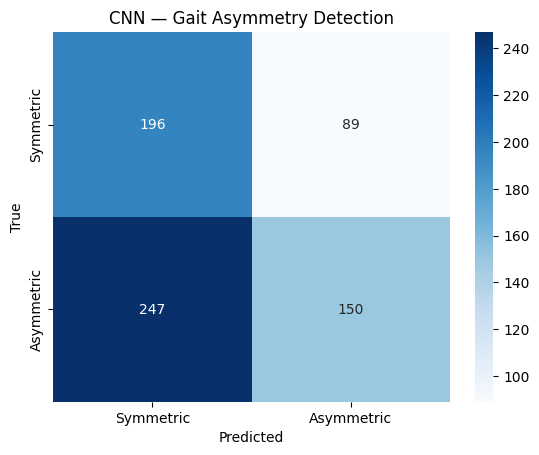

In [ ]:
# CNN Model — Gait Asymmetry Detection from Raw IMU Windows

# Load the .npz dataset
data = np.load('all_subject_raw_windows.npz')
X = data['X']
y = data['label_moderate']
groups = data['patient_id']

# Filter out undefined gait cycle with label = 2
valid_idx = y != 2
X = X[valid_idx]
y = y[valid_idx]
groups = groups[valid_idx]

# Normalize per-feature
X = X.astype(np.float32)
X_mean = X.mean(axis=(0, 1), keepdims=True)
X_std = X.std(axis=(0, 1), keepdims=True)
X = (X - X_mean) / (X_std + 1e-7)

# GroupKFold Cross-Validation
gkf = GroupKFold(n_splits=5)
y_true_all, y_pred_all = [], []

for fold, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups)):
    print(f'\nFold {fold + 1}')

    model = cnn_model(input_shape=X.shape[1:])
    history = model.fit(X[train_idx], y[train_idx], epochs=10, batch_size=32, verbose=0)

    y_pred_prob = model.predict(X[test_idx]).flatten()
    y_pred = (y_pred_prob >= 0.5).astype(int)

    y_true_all.extend(y[test_idx])
    y_pred_all.extend(y_pred)

# Final Confusion Matrix
cm = confusion_matrix(y_true_all, y_pred_all)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Symmetric', 'Asymmetric'], yticklabels=['Symmetric', 'Asymmetric'])
plt.title('CNN — Gait Asymmetry Detection')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Shallow MLP Architecture

In [11]:
def shallow_mlp_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
    return model


Fold 1
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
              precision    recall  f1-score   support

           0      0.593     0.444     0.508        72
           1      0.506     0.651     0.569        63

    accuracy                          0.541       135
   macro avg      0.549     0.548     0.539       135
weighted avg      0.552     0.541     0.537       135


Fold 2
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
              precision    recall  f1-score   support

           0      0.365     0.585     0.449        53
           1      0.577     0.357     0.441        84

    accuracy                          0.445       137
   macro avg      0.471     0.471     0.445       137
weighted avg      0.495     0.445     0.444       137


Fold 3
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
              precision    recall  f1-score   support

           0      0.325     0.521     0.400        48
           1      0.603     0.402     0.483        87

    accuracy                          0.444 

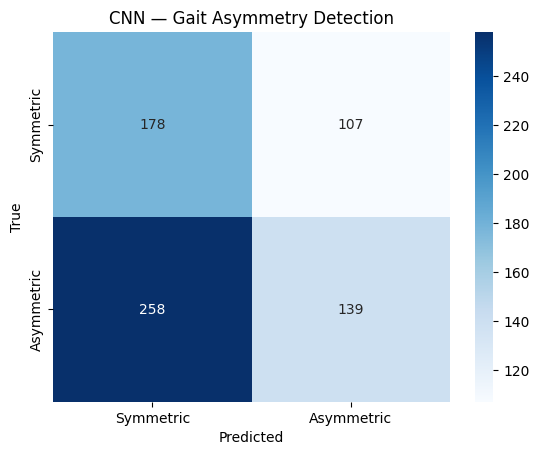

In [ ]:
# Shallow MLP Model — Gait Asymmetry Detection from Raw IMU Windows

# Load the .npz dataset
data = np.load('all_subject_raw_windows.npz')
X = data['X']
y = data['label_moderate']
groups = data['patient_id']

# Filter out undefined gait cycle with label = 2
valid_idx = y != 2
X = X[valid_idx]
y = y[valid_idx]
groups = groups[valid_idx]

# Normalize per-feature
X = X.astype(np.float32)
X_mean = X.mean(axis=(0, 1), keepdims=True)
X_std = X.std(axis=(0, 1), keepdims=True)
X = (X - X_mean) / (X_std + 1e-7)

# GroupKFold Cross-Validation
gkf = GroupKFold(n_splits=5)
y_true_all, y_pred_all = [], []

for fold, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups)):
    print(f'\nFold {fold + 1}')

    model = shallow_mlp_model(input_shape=X.shape[1:])
    history = model.fit(X[train_idx], y[train_idx], epochs=10, batch_size=32, verbose=0)

    y_pred_prob = model.predict(X[test_idx]).flatten()
    y_pred = (y_pred_prob >= 0.5).astype(int)

    y_true_all.extend(y[test_idx])
    y_pred_all.extend(y_pred)

# Final Confusion Matrix
cm = confusion_matrix(y_true_all, y_pred_all)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Symmetric', 'Asymmetric'], yticklabels=['Symmetric', 'Asymmetric'])
plt.title('CNN — Gait Asymmetry Detection')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Observations

Trained both CNN and Shallow MLP:
1. Tried all label granularities: strict, moderate, lenient
2. All models yield ~50% F1 score (≅ random guessing)
3. This persists across architectures and labels

<br></br>

| Observation                     | Comment                                                                                  |
| -----------------------------   | ---------------------------------------------------------------------------------------- |
| Data pipeline seems to be solid | Good design, clean separation and usage of raw window data sets                          |
| Models seem appropriate         | CNN + MLP are lightweight and suitable for time-windowed data for real life applications |
| The results are **expected**    | Models can’t learn much from limited and low-diversity data                              |

<br></br>

### Improvements  
- We need to create a bigger and more diverse dataset, including more users, experiments and data windows.

## 3. Stride Asymmetry 

In [ ]:
clean_extra_files(healthy_dir)
clean_extra_files(stroke_dir)